# Example of using LIFT

This codes provides an example of how to initialize and use all the necessary modules needed to perform focal-plane wavefront sensing with LIFT

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
from warnings import warn

try:
    import cupy as cp
except ImportError or ModuleNotFoundError:
    warn('CuPy is not installed, using NumPy backend...')
    cp = np

from modules.Telescope import Telescope 
from modules.Detector import Detector
from modules.Source import Source
from modules.Zernike import Zernike
from modules.LIFT import LIFT
from tools.misc import mask_circle, optimal_img_size

# converts CuPy arrays to NumPy arrays
def npy(x):
    if hasattr(x, 'get'):
        return x.get()
    else:
        return x

### Initialize the telescope and the detector

LIFT intrinsically relies on a model of a system producing PSFs. Usually, such system involves a telecope, a detector, and a target seen by the telescope.

In [2]:
D = 8.0 # [m]
pixel_size = 24e-6 # [m]
ang_pixel = 12.3 # [mas]
f = pixel_size / ang_pixel * 206264806.71915 # [m]
# Lets imagine we have DITs of 10 frames with total 1 second exposure
# This is to generate a synthetic PSF 
sampling_time = 0.1 # [s]
num_samples = 10 # Total: 1 second exposure

pupil_mask = mask_circle(127, 64) - mask_circle(127, 16) # Initialize pupil mask with central obscuration

# If the number of pixels in image is odd, the code will automatically center generated PSFs to central pixel in the middle
tel = Telescope(img_resolution    = 21, # Will be changed later in this cell
                pupil             = pupil_mask,
                diameter          = D,
                focalLength       = f,
                pupilReflectivity = 1.0, # Perfectly reflecting pupil
                gpu_flag          = True) # Prefer using GPU for the calculations

det = Detector(pixel_size     = pixel_size,
                sampling_time = sampling_time,
                samples       = num_samples,
                RON           = 2.0, # used to generate PSF or the synthetic R_n [photons]
                QE            = 0.7) # currently not used

det.object = None # You can defin a an arbitrary convolution kernel to an object, but we are not doing it here 
det * tel
ngs = Source([('H', 19.5), ('J', 19.5)]) # Initialize a polychromatic target, flux from boths bands adds up
ngs * tel # attach the source to the telescope

N_modes_simulated = 10 # Number of orders to simulate
tel.img_resolution = optimal_img_size(tel, N_modes_simulated, force_odd=True) # Change the the optimal image size required to represent the specified number of modes

# Initialize modal basis
Z_basis = Zernike(modes_num=100)
Z_basis.computeZernike(tel)

diversity_shift = 200e-9 # [m]
astig_diversity = Z_basis.Mode(4)*diversity_shift


-------------------- TELESCOPE --------------------
Diameter 			8.0 	 [m]
Pupil sampling 			127 	 [pix]
------------------------------------------------


### Inialize random low-order modal coefficients
LIFT is primary intended for low-order modes sensing. Let's initalize some random LO coefficients according to an arbitrary distribution

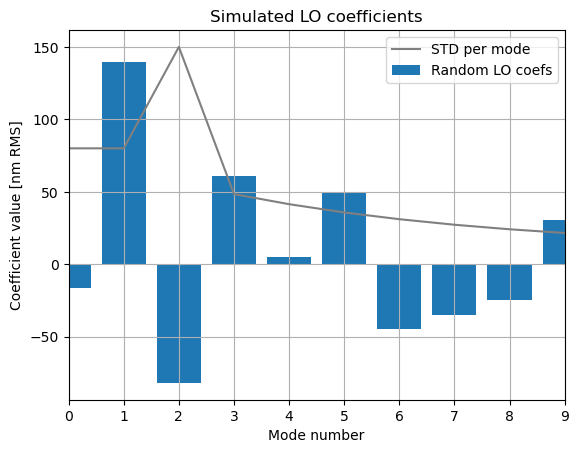

In [3]:
LO_dist_law = lambda x, A, B, C: A / cp.exp(B*cp.abs(x)) + C
x = cp.arange(N_modes_simulated)
LO_distribution_std    = LO_dist_law(x, *[70, 0.2, 10])
LO_distribution_std[1] = LO_distribution_std[0]
LO_distribution_std[2] = 150
LO_distribution_std   *= 1e-9 # [nm] -> [m]

LO_distribution_mean = cp.zeros(N_modes_simulated) # just zeros in this example

coefs_LO = cp.random.normal(LO_distribution_mean, LO_distribution_std, N_modes_simulated)

plt.title('Simulated LO coefficients')
plt.bar(npy(x), npy(coefs_LO)*1e9, label='Random LO coefs')
plt.plot(npy(x), npy(LO_distribution_std)*1e9, label='STD per mode', color='gray')
plt.xticks(npy(x))
plt.xlim(0, N_modes_simulated-1)
plt.grid()
plt.legend()
plt.ylabel('Coefficient value [nm RMS]')
plt.xlabel('Mode number')
plt.show()

### Simulate PSF

Simulate a noisy PSF using the coefficients generated previously

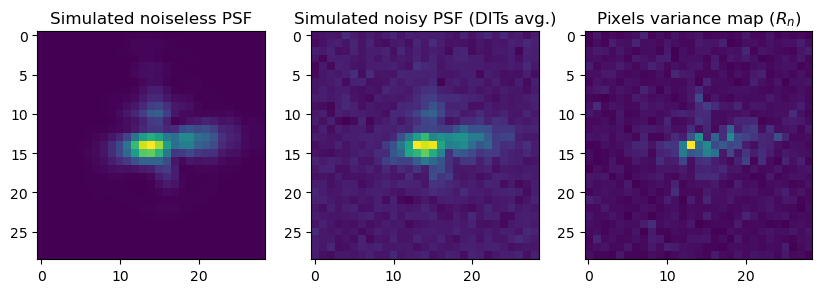

In [4]:
def PSFfromCoefs(coefs):
    tel.src.OPD = Z_basis.wavefrontFromModes(tel,coefs) + astig_diversity # Don't forget to add the diversity term
    PSF = tel.ComputePSF()
    tel.src.OPD *= 0.0 # zero out just in case
    return PSF

PSF_noiseless = PSFfromCoefs(coefs_LO)
PSF_noisy_DITs, _ = tel.det.getFrame(PSF_noiseless, noise=True, integrate=False) # Adding noise to the PSF and generating a sequence of frames

PSF_noiseless = npy(PSF_noiseless)

R_n = PSF_noisy_DITs.var(axis=2) # LIFT uses pixel variance as weighting map; To weight all pixels equally set R_n to xp.ones_like(PSF)
PSF_data = PSF_noisy_DITs.mean(axis=2) # input PSF
PSF_data = cp.array(PSF_data)
R_n = cp.array(R_n)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].set_title('Simulated noiseless PSF')
ax[1].set_title('Simulated noisy PSF (DITs avg.)')
ax[2].set_title(r'Pixels variance map ($R_n$)')
ax[0].imshow(PSF_noiseless)

ax[1].imshow(npy(PSF_data))
ax[2].imshow(npy(R_n))

plt.show()

### Finally, estimate with LIFT

As inputs, LIFT takes the model of an optical system and an image and tries to optimize the vector of modal coefficients. This code implement both unbiase _Maximum-Likelihood (ML)_ and _Maximum A posteriori Probability (MAP)_ estimators.

In [6]:
estimator = LIFT(tel, Z_basis, astig_diversity, 20)

modes = [0,1,2,3,4,5,6,7,8,9] # Selected Zernike modal coefficients
# Note! Sometimes, for ML-estimation it is better to exlude an order coincding with the diversity term (e.g. 4th order in this case) to reduce the cross coupling between modes

coefs_mean = LO_distribution_mean   # Initial guess for the mean value of the modal coefficients (for MAP estimator)
coefs_var  = LO_distribution_std**2 # Initial guess for the variance of the modal coefficients (for MAP estimator)

coefs_estimated_ML,  PSF_estimated_ML, _  = estimator.Reconstruct(PSF_data, R_n=R_n, mode_ids=modes, optimize_norm='sum')
coefs_estimated_MAP, PSF_estimated_MAP, _ = estimator.ReconstructMAP(PSF_data, R_n=R_n, A_mean=coefs_mean, A_var=coefs_var, mode_ids=modes, optimize_norm='sum')

c:\Users\akuznets\Projects\LIFT\LIFT_full\LIFT\tests\..\modules\LIFT.py:72: UserWarning: Mode number exceeds the number of modes in the basis. Removed. Consider regenerating the modal basis with more modes included.
  warnings.warn('Mode number exceeds the number of modes in the basis. Removed. Consider regenerating the modal basis with more modes included.')


### Plot the results for the ML-estimator

In [ ]:
def GenerateWF(coefs):
    return (Z_basis.wavefrontFromModes(tel, coefs) + astig_diversity)*1e9 # [m]

calc_WFE = lambda WF: cp.std(WF[pupil_mask == 1])

WF_0 = GenerateWF(coefs_LO)
WF_ML = GenerateWF(coefs_estimated_ML)

WF_0  = npy(WF_0)
WF_ML = npy(WF_ML)

d_WF = WF_0-WF_ML
d_WFE = calc_WFE(d_WF)
WFE_0 = calc_WFE(WF_0)

c_lim = np.max([np.max(np.abs(WF_0)), np.max(np.abs(WF_ML)), np.max(np.abs(d_WF))])

# Compare PSFs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(PSF_noiseless)
ax[0].set_title('Simulated noiseless PSF')
ax[1].imshow(npy(PSF_estimated_ML))
ax[1].set_title('Estimated PSF (LIFT)')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Compare wavefronts
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(WF_0, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[0].set_title('Simulated WF')
ax[1].imshow(WF_ML, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[1].set_title('Estimated WF')
ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[2].set_title('WF difference')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# Add colorbar
cax = fig.add_axes([0.92, 0.27, 0.02, 0.45])
fig.colorbar(ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic'), cax=cax)
cax.set_ylabel('[nm RMS]')
plt.show()

print(f'Introduced WF: {WFE_0:.2f}, WFE: {d_WFE:.2f} [nm RMS]')

### Plot the results for the MAP-estimator

In [ ]:
WF_MAP = GenerateWF(coefs_estimated_MAP)

if hasattr(WF_MAP, 'device'): WF_MAP = WF_MAP.get()

if hasattr(PSF_estimated_MAP, 'device'): PSF_estimated_MAP = PSF_estimated_MAP.get()

d_WF  = WF_0-WF_MAP
d_WFE = calc_WFE(d_WF)

c_lim = np.max([np.max(np.abs(WF_0)), np.max(np.abs(WF_MAP)), np.max(np.abs(d_WF))])

# Compare PSFs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(PSF_noiseless)
ax[0].set_title('Simulated noiseless PSF')
ax[1].imshow(PSF_estimated_MAP)
ax[1].set_title('Estimated PSF (LIFT)')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Compare wavefronts
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(WF_0, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[0].set_title('Simulated WF')
ax[1].imshow(WF_MAP, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[1].set_title('Estimated WF')
ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[2].set_title('WF difference')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# Add colorbar
cax = fig.add_axes([0.92, 0.27, 0.02, 0.45])
fig.colorbar(ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic'), cax=cax)
cax.set_ylabel('[nm RMS]')
plt.show()

print(f'Introduced WF: {WFE_0:.2f}, WFE: {d_WFE:.2f} [nm RMS]')